In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# zipfile 푸는 용도
#import zipfile

#with zipfile.ZipFile('/content/drive/MyDrive/roots.zip', 'r') as zip_ref:
#   zip_ref.extractall('/content/drive/MyDrive/')


In [9]:
from logging import root
import os
from datetime import datetime
import numpy as np
import cv2
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import gc

# 폴더 안의 모든 파일과 폴더를 가져오는 함수
def get_random_files_in_folder(root_folder, num_files):
    files = []
    for folderpath in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folderpath)
        for file in os.listdir(folder_path):
            if file.endswith("jpg"):
                files.append(os.path.join(root_folder, folderpath, file))

    # random.sample()을 이용해 리스트에서 무작위로 num_files개의 파일을 선택
    random_files = random.sample(files, num_files)

    return random_files


# 'train' 폴더 안의 모든 폴더를 가져오고 각 폴더 안의 파일을 출력
import os
import numpy as np
from datetime import datetime

def load_images_and_labels(root_folder, image_shape):
    images = []
    labels = []
    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)
        if "readme.txt" in os.listdir(folder_path):
          print(folder_path)
          continue
        if os.path.isdir(folder_path):
            # Get date from folder name
            date_str = folder_name.split('_')[1]
            #date = datetime.strptime(date_str, '%y%m%d')

            # Initialize min_time to None
            min_time = None

            file_list = os.listdir(folder_path)
            for filename in file_list:
                if filename.endswith(".jpg"):

                    # Get time from filename
                    time_str = filename.split('_')[1][0:12]
                    time = datetime.strptime(time_str, '%y%m%d%H%M%S')  # Convert to seconds

                    # Set min_time to the time of the first image
                    if min_time is None:
                        min_time = time
                    elif time < min_time:
                        min_time = time

            # Load images and labels
            for filename in file_list:
                if filename.endswith(".jpg"):
                    img = cv2.imread(os.path.join(folder_path, filename))
                    if img is None:
                      continue  # Skip this file
                    img = cv2.resize(img, image_shape)  # Resize the image
                    images.append(img)
                    # Get time from filename
                    curtime_str = filename.split('_')[1][0:12]
                    curtime = datetime.strptime(curtime_str, '%y%m%d%H%M%S')  # Convert to seconds
                    # Calculate elapsed time and convert to label
                    elapsed_time = (curtime - min_time).total_seconds() // 3600  # Convert to hours
                    if elapsed_time <= 12:
                        label = 1
                    elif elapsed_time <= 24:
                        label = 2
                    elif elapsed_time <= 36:
                        label = 3
                    elif elapsed_time <= 48:
                        label = 4
                    elif elapsed_time <= 60:
                        label = 5
                    elif elapsed_time <= 72:
                        label = 6
                    else:
                        label = 7  # More than 72 hours
                    labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels




/content/drive/MyDrive/roots/train/root1_220919


KeyboardInterrupt: ignored

In [10]:
# Define the new image shape
image_shape = (128, 128)

# Load train images and labels
train_images, train_labels = load_images_and_labels('/content/drive/MyDrive/roots/train', image_shape)


# Clear memory
gc.collect()

# Load test images and labels
test_images, test_labels = load_images_and_labels('/content/drive/MyDrive/roots/test', image_shape)

# Clear memory
gc.collect()

# Preprocess images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0





# Convert labels to categorical one-hot encoding
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

num_labels = train_labels.shape[1]  # Get the number of labels

# Build model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_shape[0], image_shape[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_labels, activation='softmax')  # Replace with the number of labels
])

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train model
# history = model.fit(train_images, train_labels,
#                     epochs=10,  # Modify as needed
#                     batch_size=32,  # Modify as needed
#                     validation_data=(test_images, test_labels))

from keras.preprocessing.image import ImageDataGenerator



/content/drive/MyDrive/roots/train/root1_220919
/content/drive/MyDrive/roots/train/root2_220914


KeyboardInterrupt: ignored

In [12]:
# Image data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.17,
    width_shift_range=0.5,
    height_shift_range=0.4,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(train_images)

# Fit the model on the batches generated by datagen.flow()
history = model.fit(datagen.flow(train_images, train_labels, batch_size=32),
                    steps_per_epoch=len(train_images) / 32,
                    epochs=10,
                    validation_data=(test_images, test_labels))

Epoch 1/10
200/200 [==============================] - 29s 143ms/step - loss: 0.1940 - accuracy: 0.6406 - val_loss: 0.2625 - val_accuracy: 0.5525
Epoch 2/10
200/200 [==============================] - 29s 145ms/step - loss: 0.1911 - accuracy: 0.6475 - val_loss: 0.2610 - val_accuracy: 0.5574
Epoch 3/10
139/200 [===================>..........] - ETA: 9s - loss: 0.1889 - accuracy: 0.6565

KeyboardInterrupt: ignored

In [17]:
from keras.callbacks import ReduceLROnPlateau

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_shape[0], image_shape[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_labels, activation='softmax')  # Replace with the number of labels
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels,
                    epochs=10,  # Modify as needed
                    batch_size=32,  # Modify as needed
                    validation_data=(test_images, test_labels),
                    callbacks=[learning_rate_reduction])


Epoch 1/10
201/201 [==============================] - 7s 23ms/step - loss: 0.1590 - accuracy: 0.7130 - val_loss: 0.5476 - val_accuracy: 0.4295 - lr: 0.0010
Epoch 2/10
201/201 [==============================] - 4s 18ms/step - loss: 0.0920 - accuracy: 0.8333 - val_loss: 0.8268 - val_accuracy: 0.4579 - lr: 0.0010
Epoch 3/10
201/201 [==============================] - 3s 17ms/step - loss: 0.0688 - accuracy: 0.8882 - val_loss: 1.1200 - val_accuracy: 0.4404 - lr: 0.0010
Epoch 4/10
201/201 [==============================] - 3s 17ms/step - loss: 0.0531 - accuracy: 0.9232 - val_loss: 1.2079 - val_accuracy: 0.4530 - lr: 0.0010
Epoch 5/10
201/201 [==============================] - 4s 18ms/step - loss: 0.0451 - accuracy: 0.9400 - val_loss: 1.1920 - val_accuracy: 0.4628 - lr: 0.0010
Epoch 6/10
201/201 [==============================] - 4s 18ms/step - loss: 0.0371 - accuracy: 0.9495 - val_loss: 1.2318 - val_accuracy: 0.4770 - lr: 0.0010
Epoch 7/10
201/201 [==============================] - 4s 18ms/st

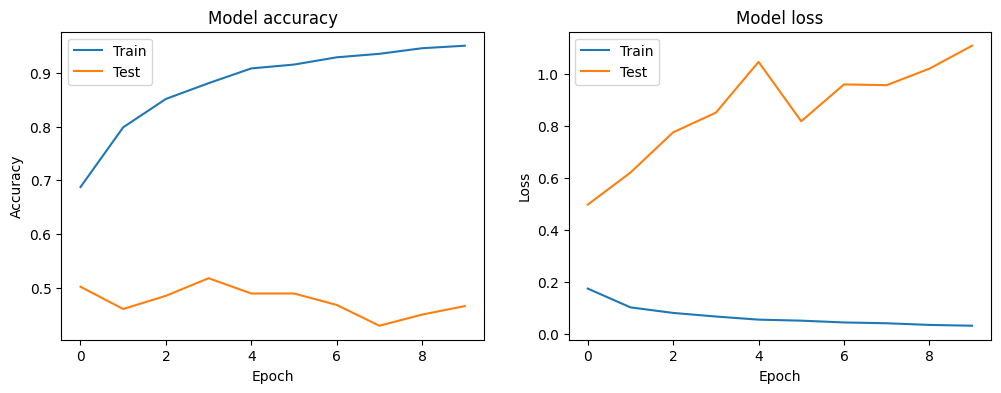

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


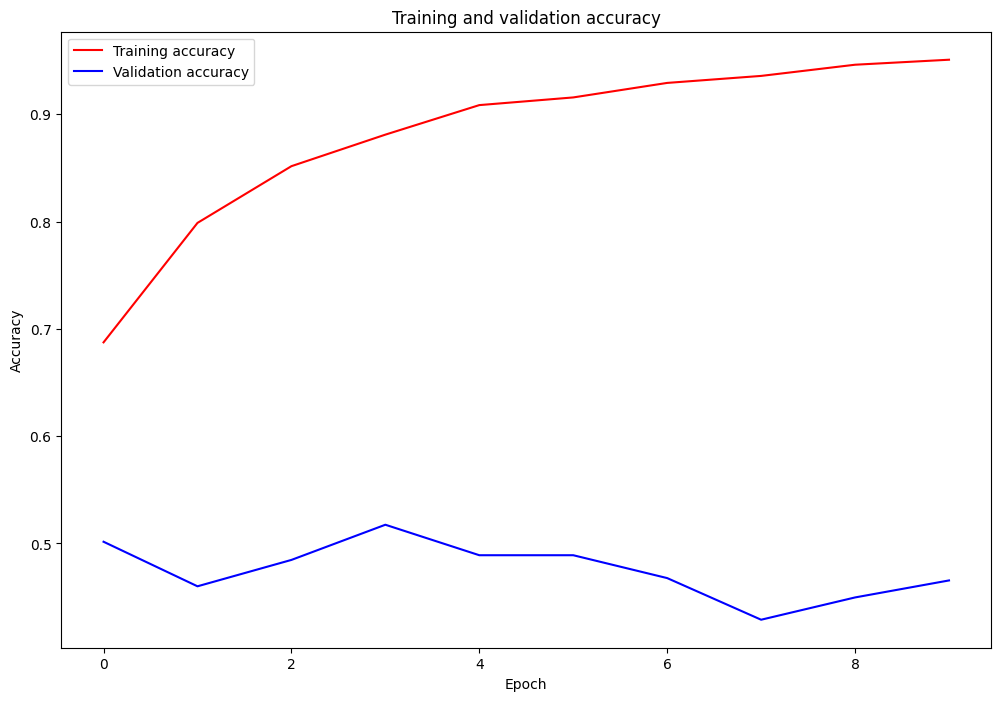

Training accuracy: 0.95
Validation accuracy: 0.47


In [15]:
import matplotlib.pyplot as plt

# Get accuracy history from the training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get the number of epochs
epochs = range(len(train_acc))

# Plot training and validation accuracy per epoch
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=0)
plt.show()

# Print the final accuracy
print(f'Training accuracy: {train_acc[-1]:.2f}')
print(f'Validation accuracy: {val_acc[-1]:.2f}')


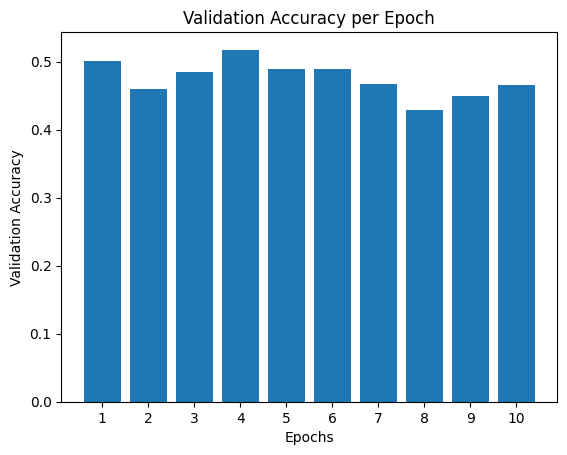

In [16]:
# 각 epoch마다의 validation 정확도를 추출
val_accuracy = history.history['val_accuracy']

# Histogram 그리기 위한 설정
epochs = range(1, len(val_accuracy) + 1)
plt.bar(epochs, val_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.xticks(epochs)
plt.show()

1/1 [==============================] - 0s 251ms/step


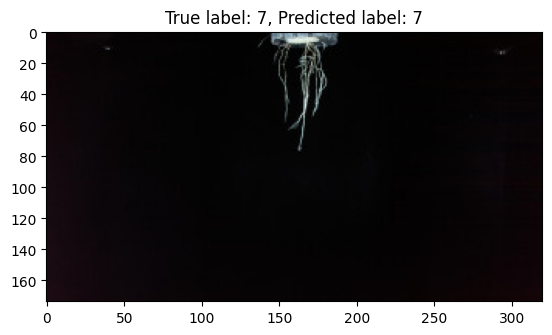

1/1 [==============================] - 0s 32ms/step


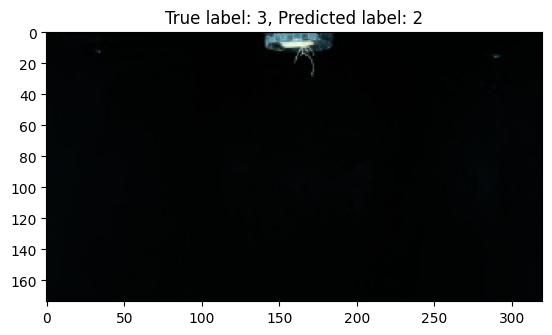

1/1 [==============================] - 0s 18ms/step


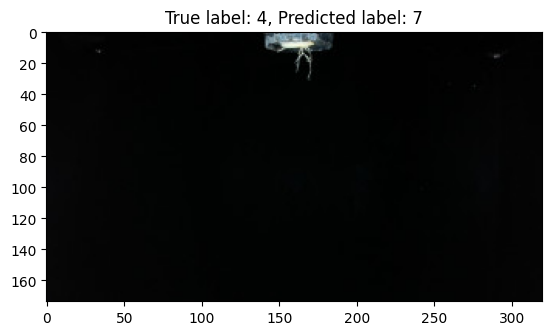

1/1 [==============================] - 0s 20ms/step


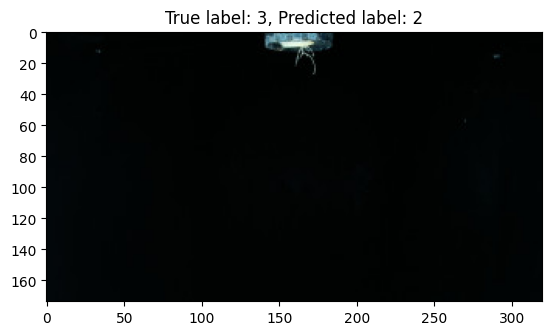

1/1 [==============================] - 0s 18ms/step


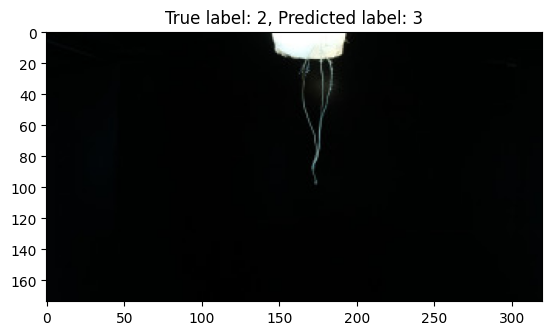

1/1 [==============================] - 0s 19ms/step


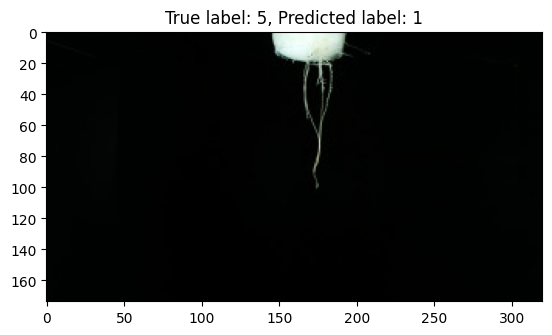

1/1 [==============================] - 0s 21ms/step


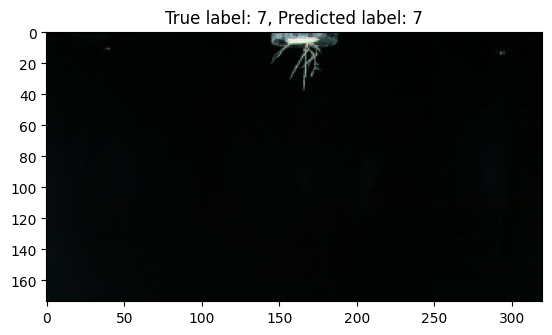

1/1 [==============================] - 0s 24ms/step


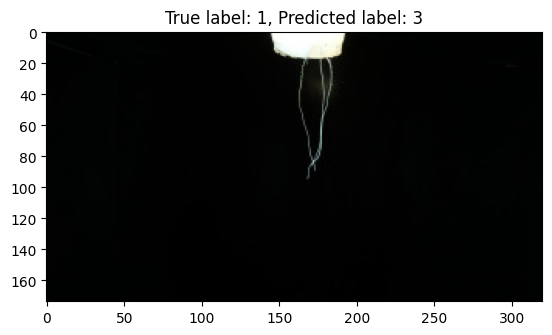

1/1 [==============================] - 0s 30ms/step


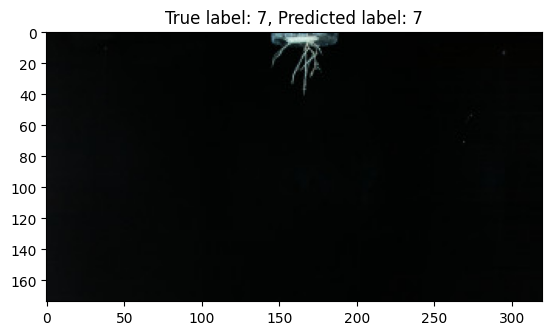

1/1 [==============================] - 0s 18ms/step


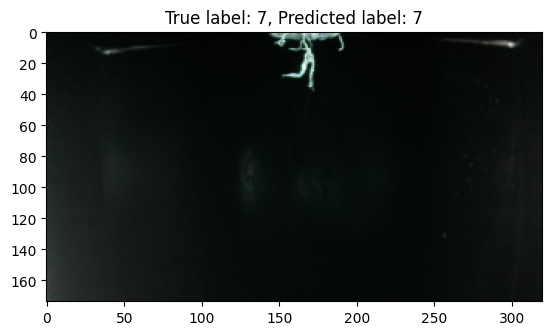

In [8]:
def get_min_time(folder_name):
    min_time = None
    for filename in os.listdir(folder_name):
        if filename.endswith(".jpg"):
            # Get time from filename
            time_str = filename.split('_')[1][0:12]  # Get '시분초'
            time = datetime.strptime(time_str, '%y%m%d%H%M%S')  # Convert to seconds
            # Set min_time to the time of the first image
            if min_time is None:
                min_time = time
            elif time < min_time:
                min_time = time
    return min_time

def predict_and_display(image_path, model, image_shape, min_time):
    # Read the image
    img = cv2.imread(image_path)
    # Resize the image
    img_resized = cv2.resize(img, image_shape)

    # Get the true label from the filename
    folder_name, filename = os.path.split(image_path)
    # Get time from filename
    time_str = filename.split('_')[1][0:12]  # Get '시분초'
    time = datetime.strptime(time_str, '%y%m%d%H%M%S')  # Convert to seconds

    # Calculate elapsed time and convert to label
    elapsed_time = (time - min_time).total_seconds() // 3600  # Convert to hours
    if elapsed_time < 12:
        true_label = 1
    elif elapsed_time < 24:
        true_label = 2
    elif elapsed_time < 36:
        true_label = 3
    elif elapsed_time < 48:
        true_label = 4
    elif elapsed_time < 60:
        true_label = 5
    elif elapsed_time < 72:
        true_label = 6
    else:
        true_label = 7  # More than 72 hours

    # Predict the label
    img_batch = np.expand_dims(img_resized, axis=0)
    img_preprocessed = img_batch.astype('float32') / 255.0
    predictions = model.predict(img_preprocessed)
    predicted_label = np.argmax(predictions)

    # Display the image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'True label: {true_label}, Predicted label: {predicted_label}')
    plt.show()

import random

trainfiles = get_random_files_in_folder('/content/drive/MyDrive/roots/test', 10)

for image_path in trainfiles:
    folder_name, _ = os.path.split(image_path)
    min_time = get_min_time(folder_name)
    predict_and_display(image_path, model, image_shape, min_time)
